<a href="https://colab.research.google.com/github/Calmepro777/Big-Model/blob/main/Experiments/Distill_new/Model_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
import os
sys.path.append('/content')

Mounted at /content/drive/


In [2]:
import torch
from torch import nn 
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
#from torchinfo import summary
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
import torchvision.models as models
from torchvision.datasets import CIFAR100

In [3]:
transform = transforms.Compose([ Resize(224, interpolation=BICUBIC),
                  CenterCrop(224),
                  ToTensor(),
                  Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),])

In [4]:
train_set = datasets.CIFAR100("/data",train = True, download=True, transform=transform)
test_set = datasets.CIFAR100("/data",train=False,download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle = False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /data/cifar-100-python.tar.gz to /data
Files already downloaded and verified


In [5]:
net = torch.load('/content/drive/MyDrive/Research/models/snet_SGD.pth')
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
cifar100 = CIFAR100("/data", transform=transform, download=True)
cls = cifar100.classes

Files already downloaded and verified


In [7]:
def plot_images(X,y,yp,M,N,cls=cls):
    f,ax = plt.subplots(M,N,sharex = True, sharey=True, figsize=(N*4,M*4))
    for i in range(M):
        for j in range(N):
            im = X[i*N+j] / 2 + 0.5
            npx = im.cpu().numpy()
            ax[i][j].imshow(np.transpose(npx, (1, 2, 0)))
            title = ax[i][j].set_title("pred:{} true:{}".format(cls[yp[i*N+j].max(dim=0)[1]],cls[y[i*N+j]]))
            plt.setp(title,color=('g' if yp[i*N+j].max(dim=0)[1]==y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


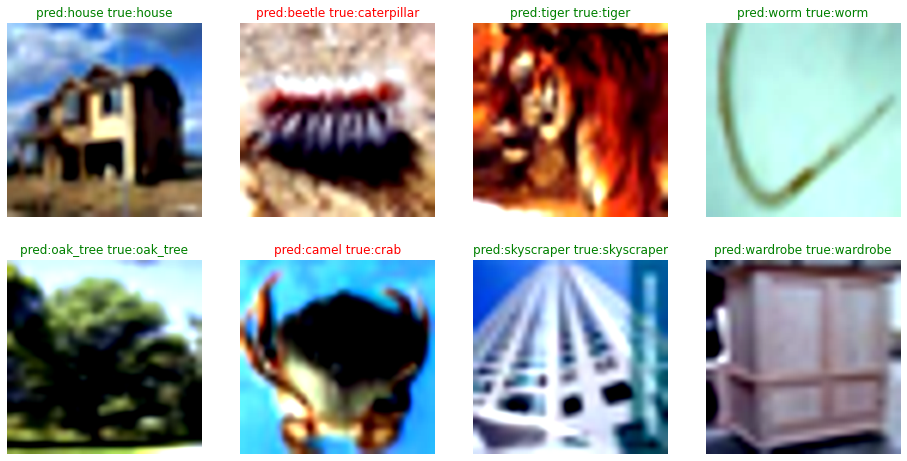

In [8]:
for X_train,y_train in train_loader:
    X_train,y_train = X_train.cuda(), y_train.cuda()
    break
y_train_p = F.softmax(net(X_train),dim=-1)
plot_images(X_train,y_train,y_train_p,2,4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


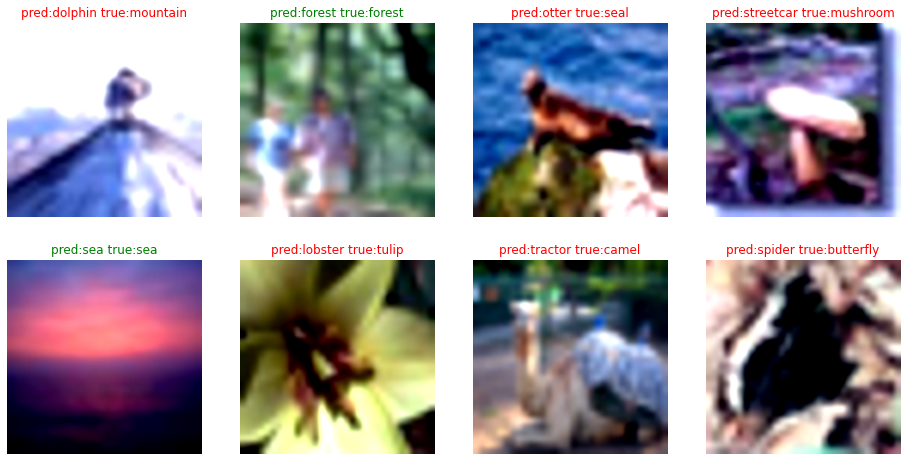

In [9]:
for X_test,y_test in test_loader:
    X_test,y_test = X_test.cuda(), y_test.cuda()
    break
y_test_p = F.softmax(net(X_test),dim=-1)
plot_images(X_test,y_test,y_test_p,2,4)

In [10]:
def scoring(x,yp,yt,k,cls=cls):
  top_scores, top_labels = yp.cpu().topk(k, dim=-1)
  plt.figure(figsize=(16, 16))

  for i, image in enumerate(x):
    plt.subplot(4, 4, 2 * i + 1)
    im = image / 2 + 0.5
    npx = im.cpu().numpy()
    plt.imshow(np.transpose(npx, (1, 2, 0)))
    title = plt.title("true:{}".format(cls[yt[i]]))
    plt.setp(title,color=('g' if yp[i].max(dim=0)[1]==yt[i] else 'r'))
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_scores.shape[-1])
    plt.grid()
    plt.barh(y, top_scores[i].detach())
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cls[index] for index in top_labels[i].numpy()])
    plt.xlabel("score")
  plt.subplots_adjust(wspace=0.5)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


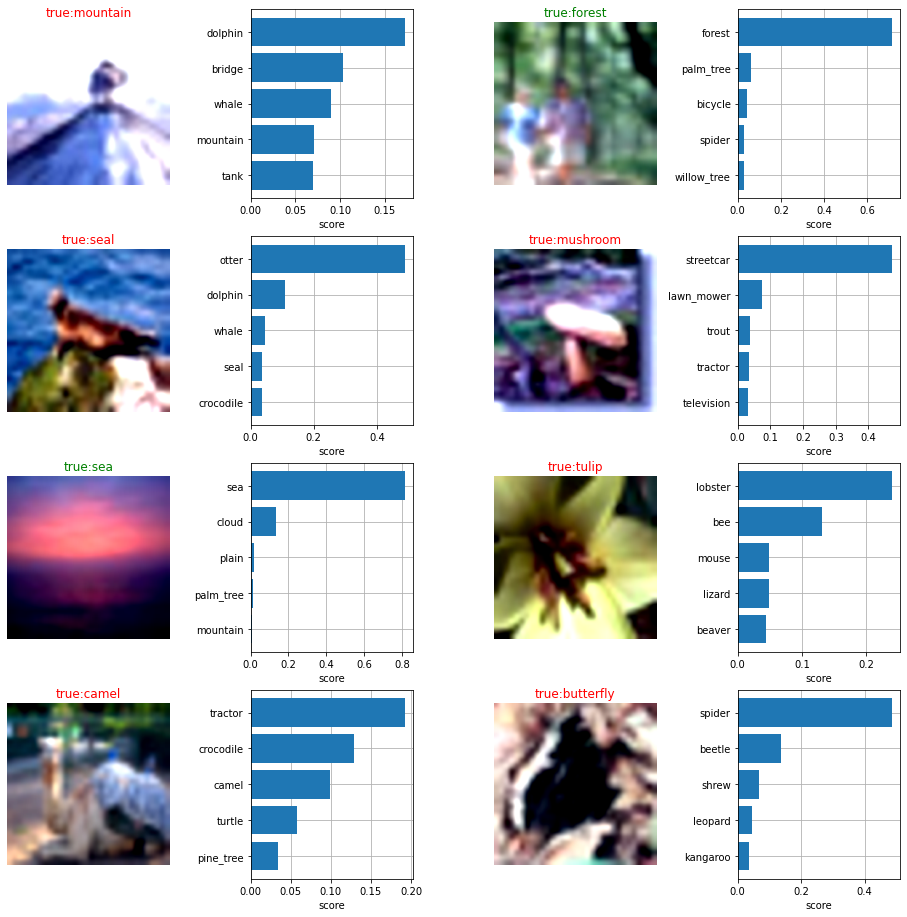

In [11]:
scoring(X_test,y_test_p,y_test,5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


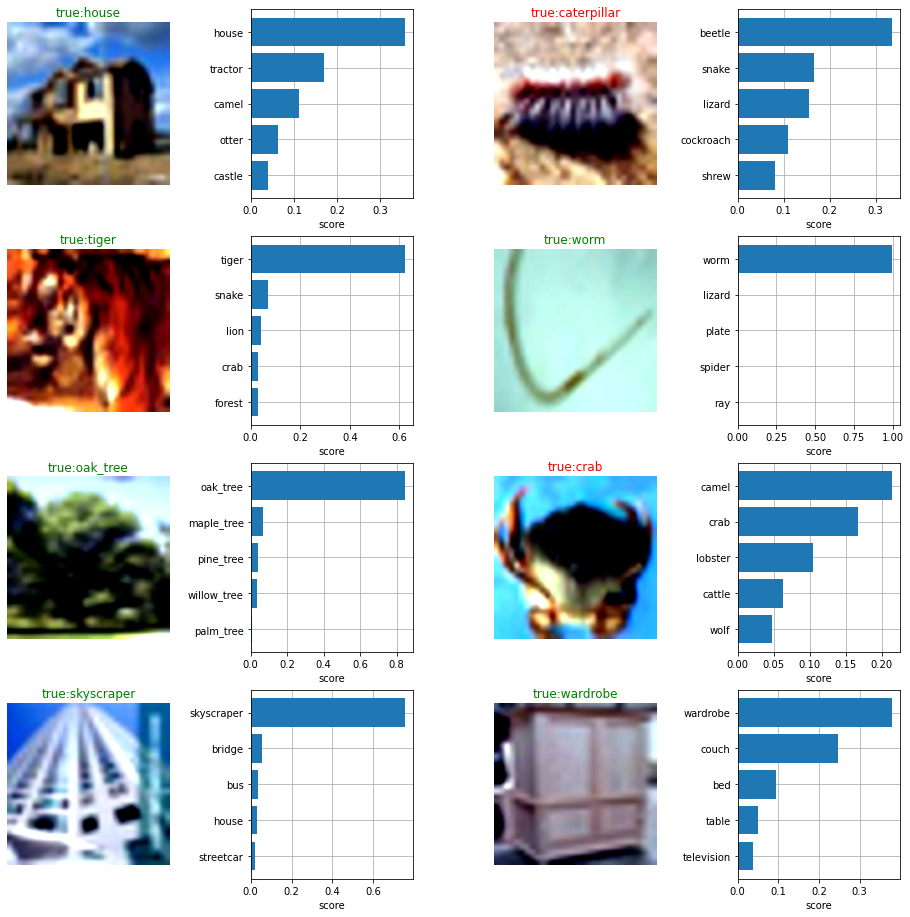

In [12]:
scoring(X_train,y_train_p,y_train,5)

In [13]:
def eval_net(loader,model,string):
  correct = 0
  total = 0
  with torch.no_grad():
    for img,labels in loader:
        img, labels = img.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model(img)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {string} images: {100 * correct / total} %')

In [14]:
eval_net(train_loader,net,"train")

Accuracy of the network on the train images: 59.898 %


In [15]:
eval_net(test_loader,net,"test")

Accuracy of the network on the test images: 49.92 %
